In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import os
import time
import random
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
from dataset import SplinterDataset, SEQ_LEN, LSPAN, RSPAN
from network import PositionalUNet, RNN
from tools import (calc_current_amplitude, process_all_waveforms, calculate_tn, get_tail_slope,check_peak_alignment,
                   inf_train_gen, LambdaLR, weights_init_normal, select_quantile, calculate_iou)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)
torch.cuda.empty_cache()

BATCH_SIZE = 16
eng_peak = 'dep'
eng_peak_load = 'fep'
home_dir='/global/homes/k/kbhimani/'
det_pulses = home_dir + f"/CPU-Net/training_data/{eng_peak}_wf_ornl.pickle"
sim_pulses = home_dir + f"/CPU-Net/training_data/{eng_peak}_wf_sim.pickle"


Running on cuda:0


In [2]:
def calculate_tp0(wf_blsub):
    """
    Calculate the tp_0 from a baseline-subtracted waveform by first finding the maximum time point
    and then searching backwards to find when the waveform first crosses zero amplitude.
    
    Parameters:
    - wf_blsub (numpy.array): Baseline-subtracted waveform.
    
    Returns:
    - tp_0 (float): Calculated time point zero.
    - tp_max (int): Index of maximum amplitude in the waveform.
    """
    # Ensure wf is a numpy array
    wf_blsub = np.asarray(wf_blsub)
    tp_max = np.argmax(wf_blsub)
    # Using np.where to find the first index meeting the condition
    cross= 0
    zero_crossings = np.where(wf_blsub[:tp_max] < cross)[0]
    if zero_crossings.size > 0:
        return zero_crossings[-1]  # Last crossing before max
    return np.nan  # Return NaN if no crossing found

dict_keys(['energy', 'tp0', 'wf'])


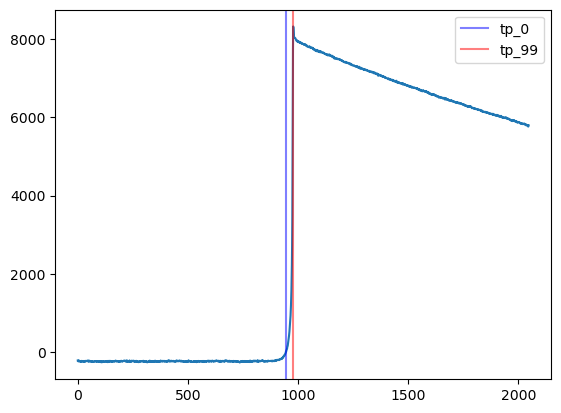

In [3]:
# An example of how to load the waveforms from pickle file
import pickle

with open(det_pulses, "rb") as openfile:
    while True:
        try:
            wdict = pickle.load(openfile, encoding='latin1')
            print(wdict.keys())  # Add this line to debug
            test_wf = wdict["wf"]
            plt.plot(test_wf)
            plt.axvline(calculate_tp0(test_wf), color='b', alpha=0.5, label='tp_0')
            plt.axvline(calculate_tn(test_wf,99),color='r', alpha=0.5, label='tp_99')
            plt.legend()
        except EOFError:
            break  # Exit the loop when end of file is reached
        except KeyError:
            print("Key 'wf' not found in dictionary.")
            continue  # Continue to the next iteration if 'wf' key is missing
        # You can add more except blocks as needed for handling other exceptions
        break

In [4]:
# import pickle
# import numpy as np

# waveforms = []  # List to store all waveforms
# file1= home_dir+ f"/nas/longleaf/home/kbhimani/CPU-Net/training_data/dep_wf_ornl.pickle"
# count=0
# with open(file1, "rb") as openfile:
#     try:
#         while count < 15000:
#             wdict = pickle.load(openfile, encoding='latin1')
#             waveforms.append(wdict["wf"])  # Append waveform to the list
#             count +=1
#     except EOFError:
#         pass  # End of file reached
#     except KeyError:
#         print("Waveform data not found.")

# # Save all waveforms together in one `.npz` file
# np.savez("dep_waveforms.npz", *waveforms)

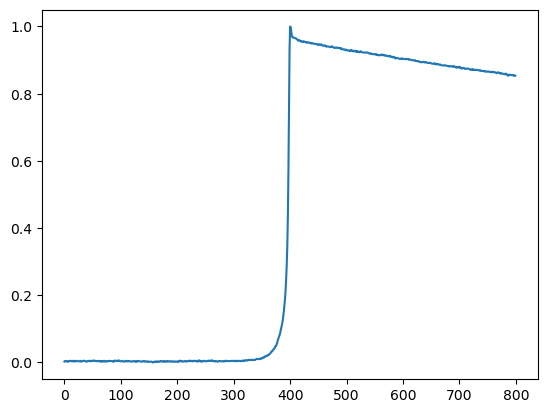

In [5]:
# An example of how to pad and normalize the waveforms
def transform(wf, tp0):
    """Transform waveform by padding based on tp0 and then normalizing."""
    wf = np.array(wf)
    # Ensure tp0 is an integer
    tp0 = int(round(tp0))
    left_padding = max(LSPAN - tp0, 0)
    right_padding = max((RSPAN + tp0) - len(wf), 0)
    # Apply padding
    wf_padded = np.pad(wf, (left_padding, right_padding), mode='edge')
    # Adjust tp0 after padding
    tp0_adjusted = tp0 + left_padding
    # Slice the waveform around the adjusted tp0 to ensure consistent length
    wf_sliced = wf_padded[(tp0_adjusted - LSPAN):(tp0_adjusted + RSPAN)]
    # Normalize the waveform after padding and slicing
    wf_normalized = normalize_waveform(wf_sliced)
    return wf_normalized
def normalize_waveform(wf):
    """Normalize waveform to have values between 0 and 1."""
    min_val = np.min(wf)
    max_val = np.max(wf)
    if max_val > min_val:
        return (wf - min_val) / (max_val - min_val)
    else:
        # Handle the case where max_val equals min_val (e.g., constant waveforms)
        return np.zeros_like(wf)  # or wf * 0 to return a waveform of zeros
tp0 = calculate_tn(test_wf,99)
transformed_wf=transform(test_wf,tp0)
plt.plot(transformed_wf)

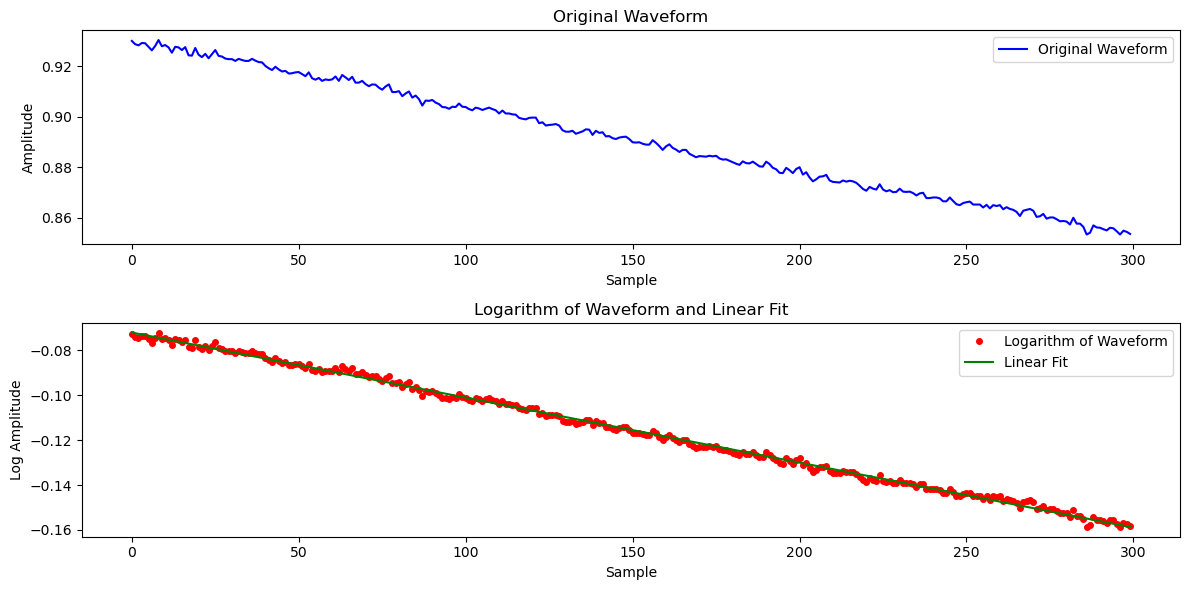

-0.0002896636164046785

In [6]:
# This show how the tail slope is calculated by doing a linear fit of log of last 300 sample od the waveform
get_tail_slope(transformed_wf,plot_sample=True)

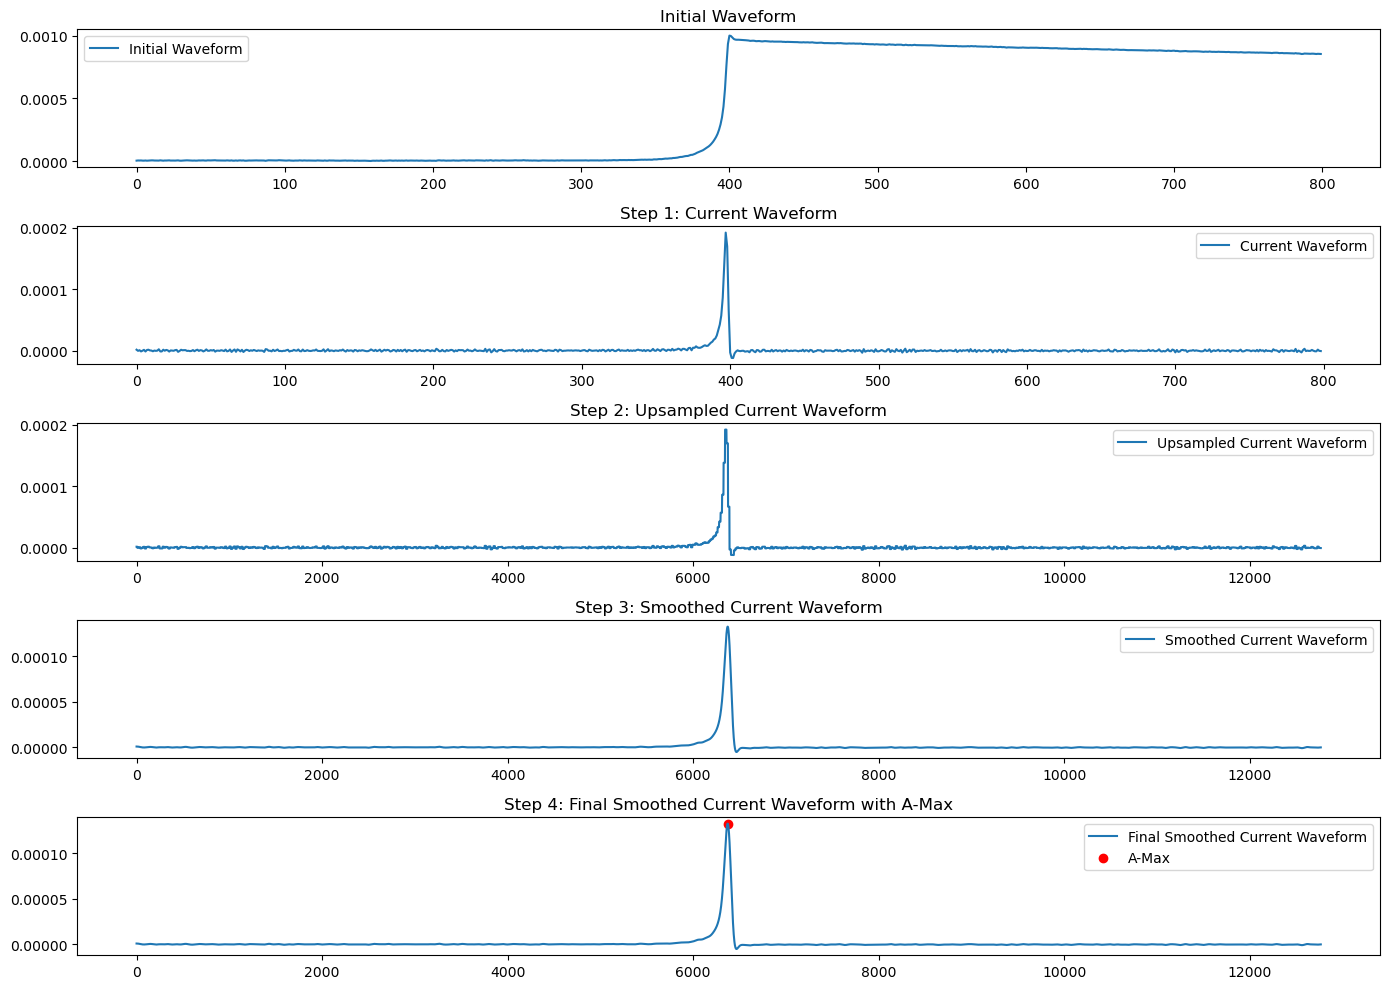

0.00013255939842522424

In [7]:
# This shows the steps for calculating the current amplitude
calc_current_amplitude(transformed_wf,plot=True)

Chi squared cut is 0.004
Tail slope cut over is -0.000282
Tail slope cut under is -0.000304
0 waveforms loaded from data.
0 waveforms loaded from data.
Number of Data events: 3974
Number of Simulations events 2989


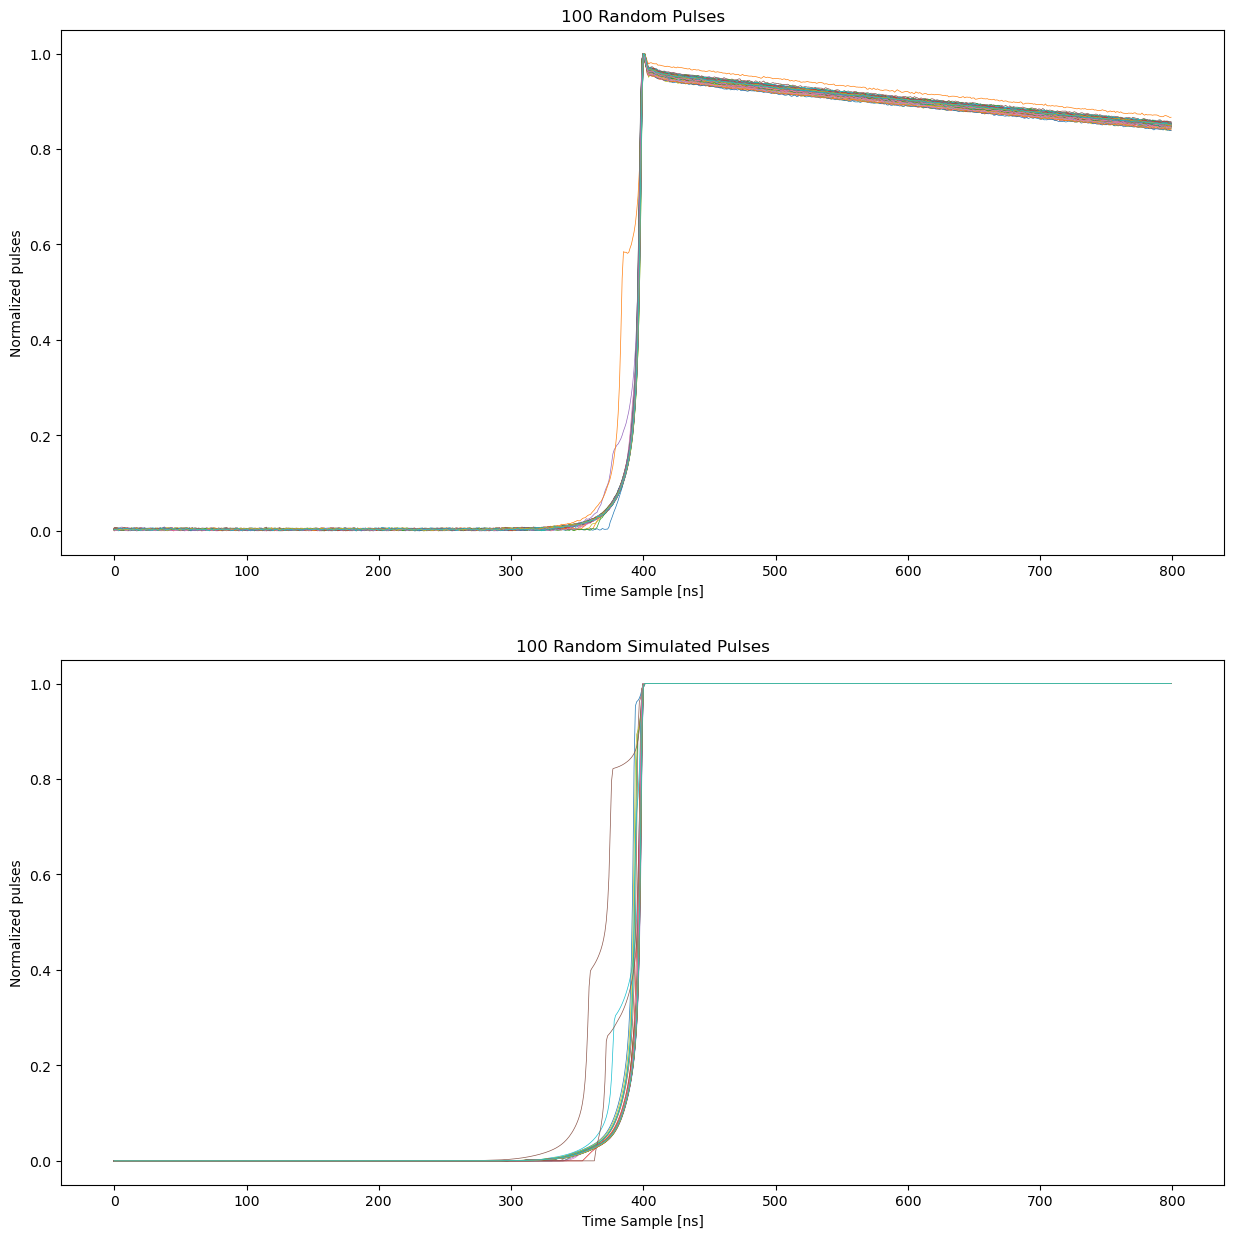

In [8]:
dataset = SplinterDataset(det_pulses, sim_pulses, n_max=1e5, chi_squared_threshold=0.004, popt_threshold_under=-3.04e-4, popt_threshold_over=-2.82e-4)
# coefficients, chi_squared_coef = dataset.fit_waveforms_to_linear_on_log(plot_sample=False)
validation_split = 0
shuffle_dataset = True
random_seed= 42222
indices = np.arange(len(dataset))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(validation_split*len(dataset))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset.set_raw_waveform(False)
train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler,  drop_last=True)
test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler,  drop_last=True)
data = inf_train_gen(train_loader)

In [16]:
#This code save the cleaned dep pulses so that we don't have to do it again
home_dir_2 = '/global/homes/k/kbhimani/CPU-Net/'
pickle_path_transformed_waveform = home_dir_2+'training_data/dep_cleaned.pickle'
with open(pickle_path_transformed_waveform, 'wb') as f_transformed:
    for wf, wf_deconv,rawwf,c in tqdm(train_loader):
        # if i==20: #processs only 10 batches
        #     break
        bsize = wf.size(0)
        for iwf in range(bsize):
            datawf = wf[iwf,0].cpu().numpy().flatten()
            if datawf is not None:
                event_dict_data = {
                    "tp0": 0,
                    "wf": datawf.astype(np.float32),
                    "event": 0,
                    "energy": 0,
                }
                pickle.dump(event_dict_data, f_transformed, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 186/186 [00:00<00:00, 402.90it/s]


5801


Text(0.5, 1.0, 'Rejected Waveforms')

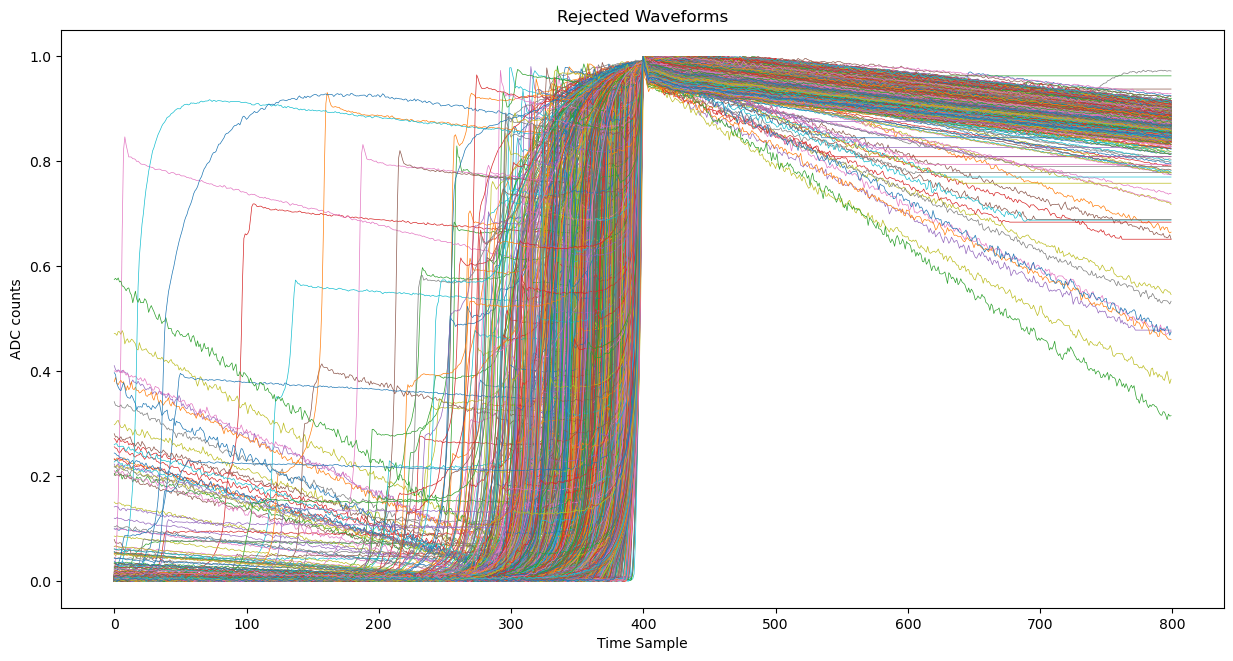

In [9]:
print(len(dataset.rejected_wf))
plt.figure(figsize=(15,7.5))
for i in range(len(dataset.rejected_wf)):
    waveform = dataset.rejected_wf[i]
    plt.plot(waveform,linewidth=0.5)
plt.title("Rejected waveforms")
plt.xlabel("Time Sample")
plt.ylabel("ADC counts")
plt.title("Rejected Waveforms")

In [10]:
ATN = PositionalUNet()
ATN.to(DEVICE)
pretrained_dict = torch.load(f'model_weights/{eng_peak_load}_ATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')
model_dict = ATN.state_dict()
model_dict.update(pretrained_dict) 
ATN.load_state_dict(pretrained_dict)
ATN.eval()

IATN = PositionalUNet()
IATN.to(DEVICE)
pretrained_dict_inv = torch.load(f'model_weights/{eng_peak_load}_IATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')

model_dict_inv = IATN.state_dict()
model_dict_inv.update(pretrained_dict_inv) 
IATN.load_state_dict(pretrained_dict_inv)
IATN.eval()

PositionalUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv1d(1, 40, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv1d(40, 40, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv1d(40, 80, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
          (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv1d(80, 

In [11]:
wf, wf_deconv, a,b = next(iter(train_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
outputs_inv = IATN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()

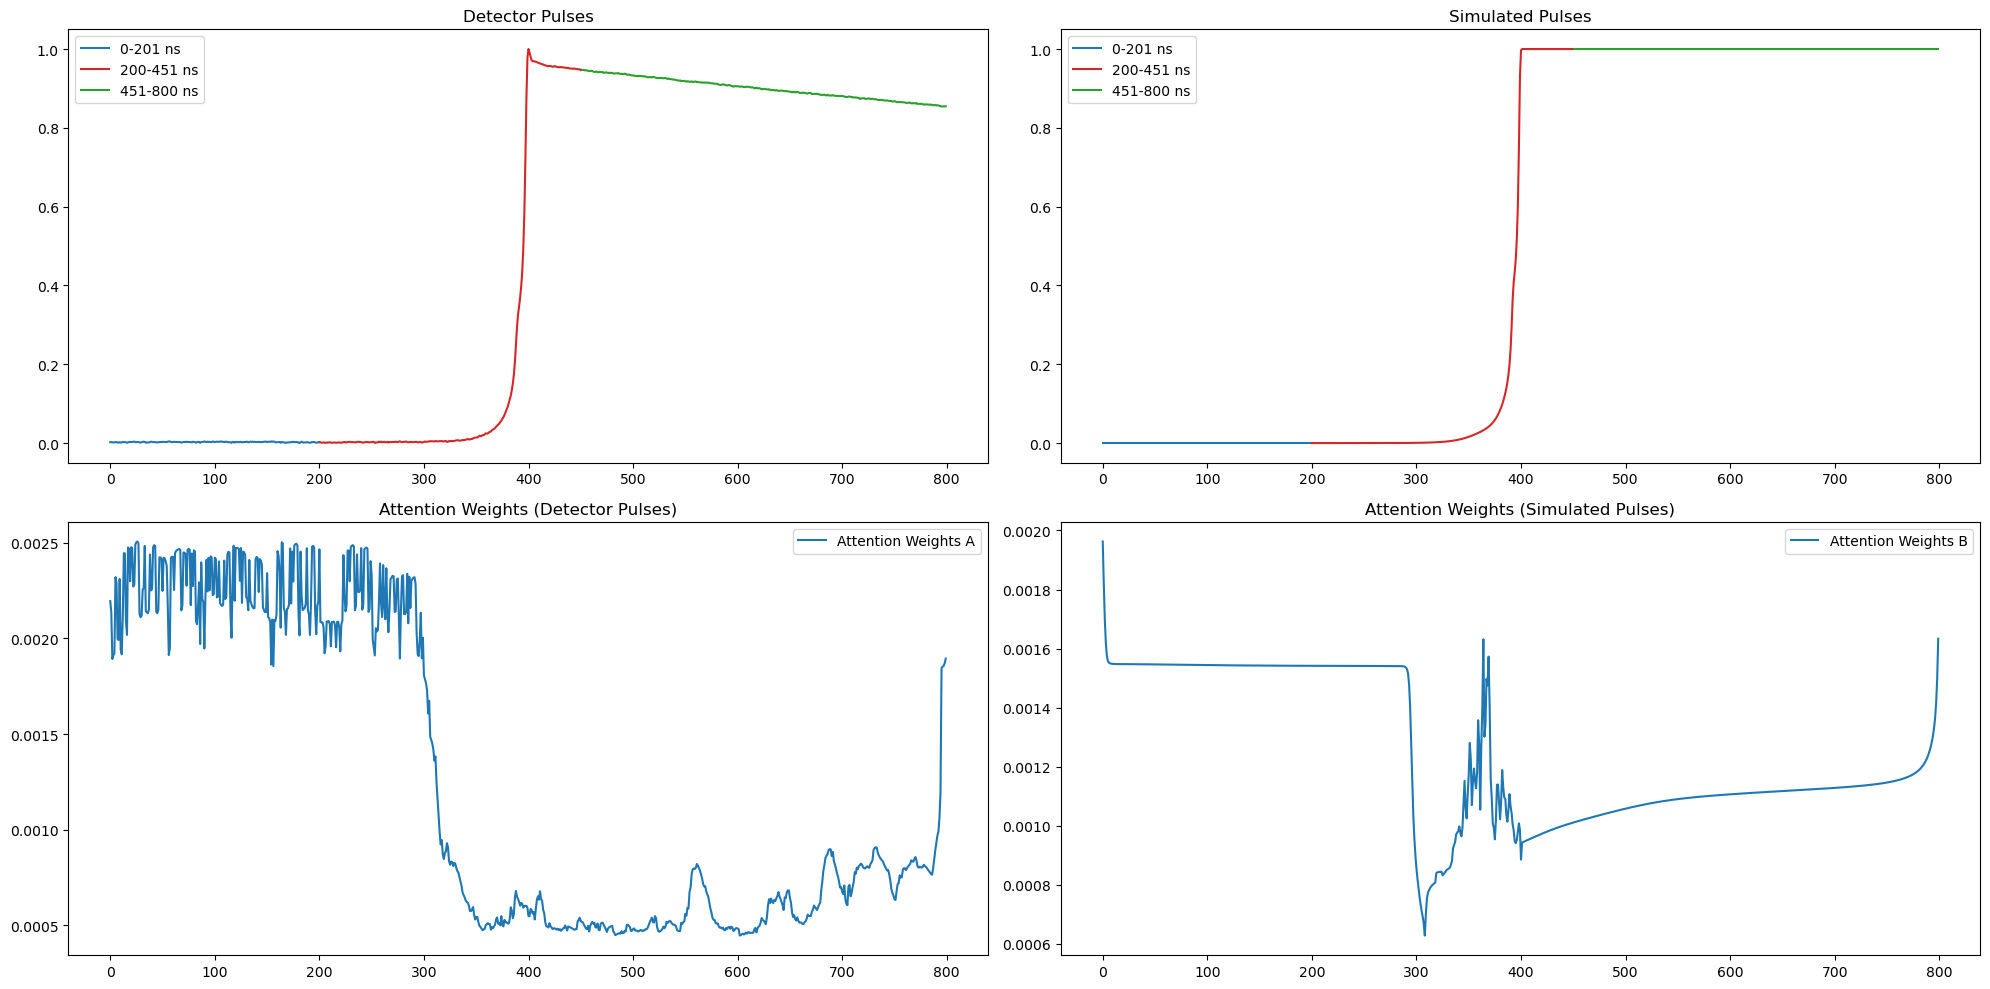

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_attention_weights_for_both(model_A, model_B, weights_path_A, weights_path_B, test_loader, device):
    # Load the saved weights for both models
    model_A.load_state_dict(torch.load(weights_path_A, map_location=device))
    model_B.load_state_dict(torch.load(weights_path_B, map_location=device))
    
    # Set both models to evaluation mode
    model_A.eval()
    model_B.eval()
    
    # Get a single batch from the test loader
    real_A, real_B, a,b = next(iter(test_loader))
    
    # Assume real_A and real_B are already on the correct device and normalized if necessary
    real_A = real_A.to(device)
    real_B = real_B.to(device)

    # Get the attention weights for the single input instance from both models
    with torch.no_grad():
        attention_weights_A = model_A.get_attention_weights(real_A).cpu().numpy()[0]  # Assuming a method that returns attention weights
        attention_weights_B = model_B.get_attention_weights(real_B).cpu().numpy()[0]  # Assuming a method that returns attention weights

    time_intervals = [(0, 201, 'tab:blue'), (200, 451, 'tab:red'), (451, 800, 'tab:green')]
    detector_pulses= real_A[0].cpu().numpy()[0]
    simulated_pulses=real_B[0].cpu().numpy()[0]
    # Create figure for visualization
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Two rows for waveforms and attention, two columns for each model
    
    # Plot waveform and attention weights for model A (Detector Pulses)
    for start, end, color in time_intervals:
        axs[0, 0].plot(np.arange(start, min(end, len(detector_pulses))), detector_pulses[start:end], color=color, label=f'{start}-{end} ns')
    axs[0, 0].set_title('Detector Pulses')
    axs[0, 0].legend()

    axs[1, 0].plot(attention_weights_A, label='Attention Weights A')
    axs[1, 0].set_title('Attention Weights (Detector Pulses)')
    axs[1, 0].legend()

    # Plot waveform and attention weights for model B (Simulated Pulses)
    for start, end, color in time_intervals:
        axs[0, 1].plot(np.arange(start, min(end, len(simulated_pulses))), simulated_pulses[start:end], color=color, label=f'{start}-{end} ns') 
    axs[0, 1].set_title('Simulated Pulses')
    axs[0, 1].legend()

    axs[1, 1].plot(attention_weights_B, label='Attention Weights B')
    axs[1, 1].set_title('Attention Weights (Simulated Pulses)')
    axs[1, 1].legend()
    
    # Adjust layout and display the plot
    plt.tight_layout()
    # plt.savefig("figs/attention_wf_plot_both.png", dpi=200)
    plt.show()
    
netD_A = RNN(get_attention=True)
netD_B = RNN(get_attention=True)
weights_path_A = f'model_weights/{eng_peak_load}_netD_A.pth'
weights_path_B = f'model_weights/{eng_peak_load}_netD_B.pth'

# Now call the function to visualize the attention weights for both models
visualize_attention_weights_for_both(netD_A, netD_B, weights_path_A, weights_path_B, train_loader,'cpu')

In [13]:
def calculate_tp0(wf_blsub, cross):
    """
    Calculate the tp_0 from a baseline-subtracted waveform by first finding the maximum time point
    and then searching backwards to find when the waveform first crosses amplitude.
    Parameters:
    - wf_blsub (numpy.array): Baseline-subtracted waveform.
    - cross (float) : Threshold for first crosses amplitude
    Returns:
    - tp_0 (float): Calculated time point zero.
    """
    # Ensure wf is a numpy array
    wf_blsub = np.asarray(wf_blsub)
    tp_max = np.argmax(wf_blsub)
    # Using np.where to find the first index meeting the condition
    zero_crossings = np.where(wf_blsub[:tp_max] < cross)[0]
    if zero_crossings.size > 0:
        return zero_crossings[-1]  # Last crossing before max
    return NaN  # Return NaN if no crossing found

In [14]:
def calc_dt(wf, cross):
    """
    Calculate the drift time as the difference between t99 and tp_0.
    """
    t99 = calculate_tn(wf, 99)
    tp_0 = calculate_tp0(wf, cross)
    if np.isnan(t99) or np.isnan(tp_0):
        return np.nan
    return t99 - tp_0

In [15]:
ts = []
gan_ts = []
ca = []
gan_ca = []
sim_ca = []
data_wf= []
siggen_wf= []
dt_sim = []
dt_data = []
dt_gan = []
i=0
for wf, wf_deconv,rawwf,c in tqdm(train_loader):
    # if i==20: #processs only 10 batches
    #     break
    bsize = wf.size(0)
    gan_wf = ATN(wf_deconv.to(DEVICE).float())
    for iwf in range(bsize):
        datawf = wf[iwf,0].cpu().numpy().flatten()
        siggenwf = wf_deconv[iwf,0].cpu().numpy().flatten()
        transfer_wf = gan_wf[iwf,0].detach().cpu().numpy().flatten()
        
        ts.append(get_tail_slope(datawf))
        gan_ts.append(get_tail_slope(transfer_wf))
        ca.append(calc_current_amplitude(datawf))
        gan_ca.append(calc_current_amplitude(transfer_wf))
        sim_ca.append(calc_current_amplitude(siggenwf))
        siggen_wf.append(siggenwf)
        data_wf.append(datawf)
        dt_sim.append(calc_dt(siggenwf, 0.005))
        dt_data.append(calc_dt(datawf, 0.005))
        dt_gan.append(calc_dt(transfer_wf, 0.005))
        
    #     plt.plot(datawf)
    #     plt.axvline(calculate_tp0(datawf, 0.002), color='b', alpha=0.5, label='tp_0')
    #     plt.axvline(calculate_tn(datawf, 99),color='r', alpha=0.5, label='tp_99')
    #     plt.legend()
    #     plt.show()
    #     plt.plot(siggenwf)
    #     plt.axvline(calculate_tp0(siggenwf,0.002), color='b', alpha=0.5, label='tp_0')
    #     plt.axvline(calculate_tn(siggenwf,99),color='r', alpha=0.5, label='tp_99')
    #     plt.legend()
    #     break
    # break
    i += 1

100%|██████████| 793/793 [00:30<00:00, 25.68it/s]


Text(0.5, 0, 'Drift time (ns)')

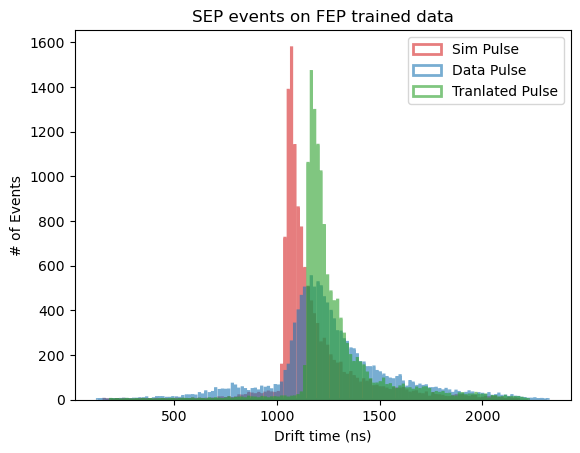

In [16]:
db = 1000 #
# db = np.linspace(0, 2000,1000)
dt_sim_plot= np.array(dt_sim)*16
dt_data_plot= np.array(dt_data)*16
dt_gan_plot= np.array(dt_gan)*16

plt.hist(dt_sim_plot, bins=db,histtype="step",linewidth=2,density=False,color="tab:red",alpha=0.6,label="Sim Pulse")
plt.hist(dt_data_plot, bins=db,histtype="step",linewidth=2,density=False,color="tab:blue",alpha=0.6,label="Data Pulse")
plt.hist(dt_gan_plot, bins=db,histtype="step",linewidth=2,density=False,color="tab:green",alpha=0.6,label="Tranlated Pulse")
plt.legend()
plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data")
plt.ylabel("# of Events")
plt.xlabel("Drift time (ns)")

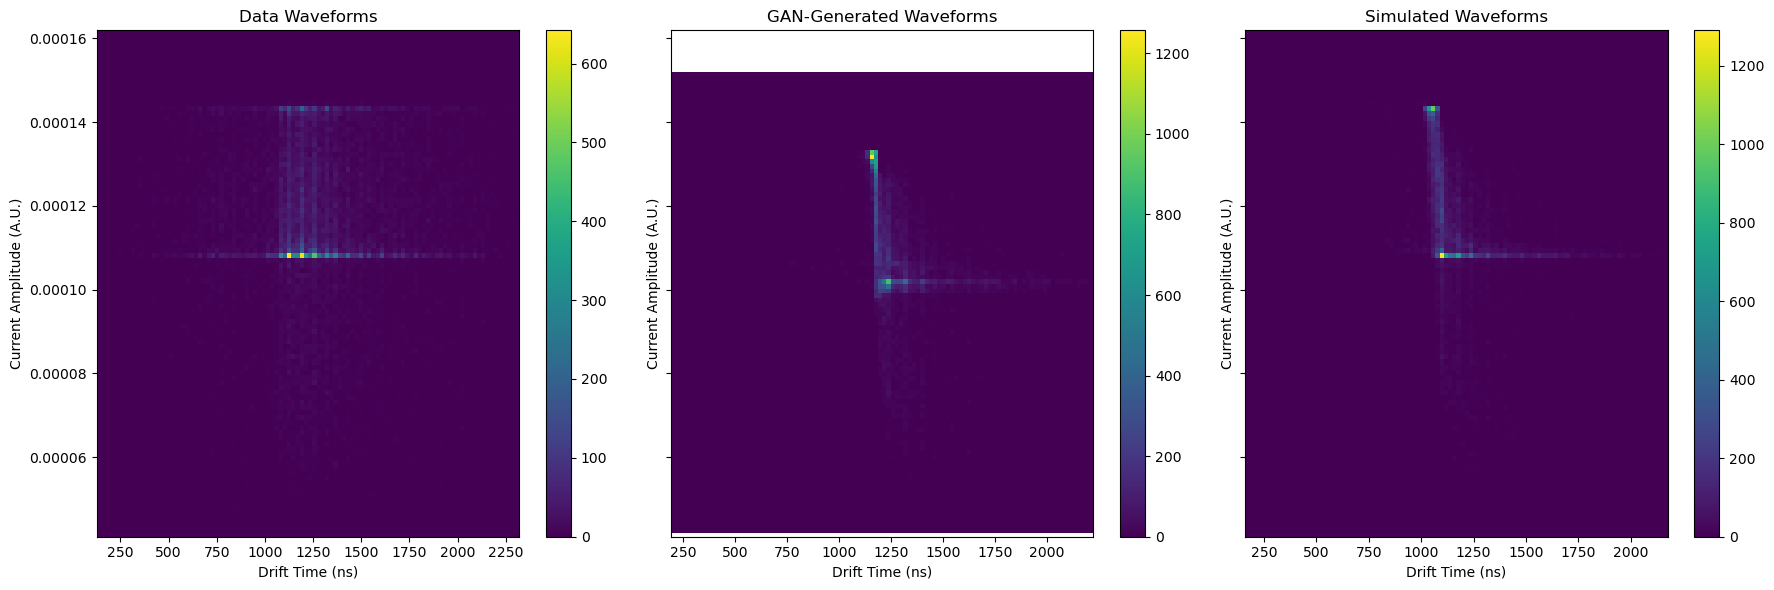

In [19]:
# Setup for plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Titles for each subplot
titles = ['Data Waveforms', 'GAN-Generated Waveforms', 'Simulated Waveforms']
data_lists = [(dt_data_plot, ca), (dt_gan_plot, gan_ca), (dt_sim_plot, sim_ca)]

# Plot each 2D histogram
for ax, title, (dt, ca) in zip(axs, titles, data_lists):
    h = ax.hist2d(dt, ca, bins=100, cmap='viridis', density=True)
    ax.set_title(title)
    ax.set_xlabel('Drift Time (ns)')
    ax.set_ylabel('Current Amplitude (A.U.)')
    plt.colorbar(h[3], ax=ax)

plt.tight_layout()
plt.show()

IoU: 92.9664012926


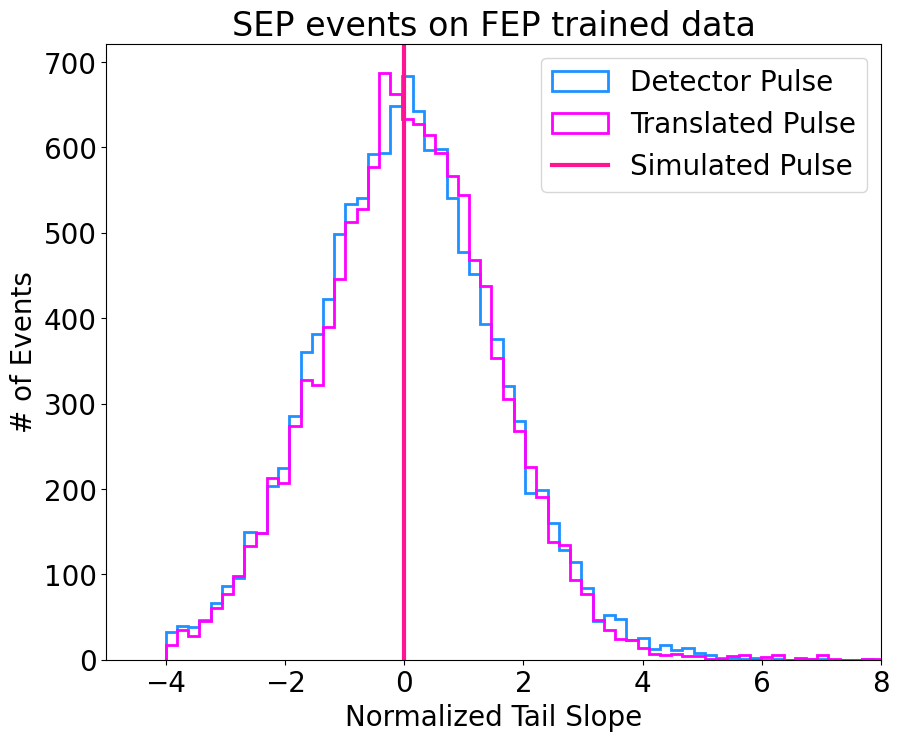

In [160]:
# Check if data is not empty after filtering and selection
if len(ts) > 0 and len(gan_ts) > 0:
    ts_quantile = select_quantile(ts)
    gan_ts_quantile = select_quantile(gan_ts)
    # Ensure selected quantile data is not empty before proceeding
    if len(ts_quantile) > 0 and len(gan_ts_quantile) > 0:
        plt.rcParams['font.size'] = 20
        plt.rcParams["figure.figsize"] = (10,8)
        mean_ts, std_ts = norm.fit(select_quantile(ts))
        ts_normalized = (np.array(ts) - mean_ts) / std_ts
        mean_gan_ts, std_gan_ts = norm.fit(select_quantile(gan_ts))
        gan_ts_normalized = (np.array(gan_ts) - mean_gan_ts) / std_gan_ts
        mean,std = norm.fit(select_quantile(ts))
        rg = np.linspace(-4,9,70)
        plt.hist(ts_normalized,bins=rg,histtype="step",linewidth=2,density=False,color="dodgerblue",label="Detector Pulse")
        plt.hist(gan_ts_normalized,bins=rg,histtype="step",linewidth=2,density=False,color="magenta",label="Translated Pulse")
        plt.axvline(x=0,color="deeppink",linewidth=3,label="Simulated Pulse")
        plt.xlim(-5,8)
        plt.legend()
        plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data")
        plt.ylabel("# of Events")
        plt.xlabel("Normalized Tail Slope")
        # plt.savefig("figs/tailslope.png",dpi=200)
        # Calculate the histograms (with density=True to normalize the histograms)
        hist_ts, _ = np.histogram(ts_normalized, bins=rg)
        hist_gan_ts, _ = np.histogram(gan_ts_normalized, bins=rg)
        # Calculate IoU for the two histograms
        iou = calculate_iou(ts_normalized, gan_ts_normalized, rg, normed=False)
        print(f"IoU: {iou:.10f}")
    else:
        print("Quantile selected data is empty or invalid.")
else:
    print("Data is empty or contains only NaN values after filtering.")


IoU between Detector Peak and Simulated Peak: 37.5865087998
IoU between Detector Peak and Translated Peak: 72.2102352562


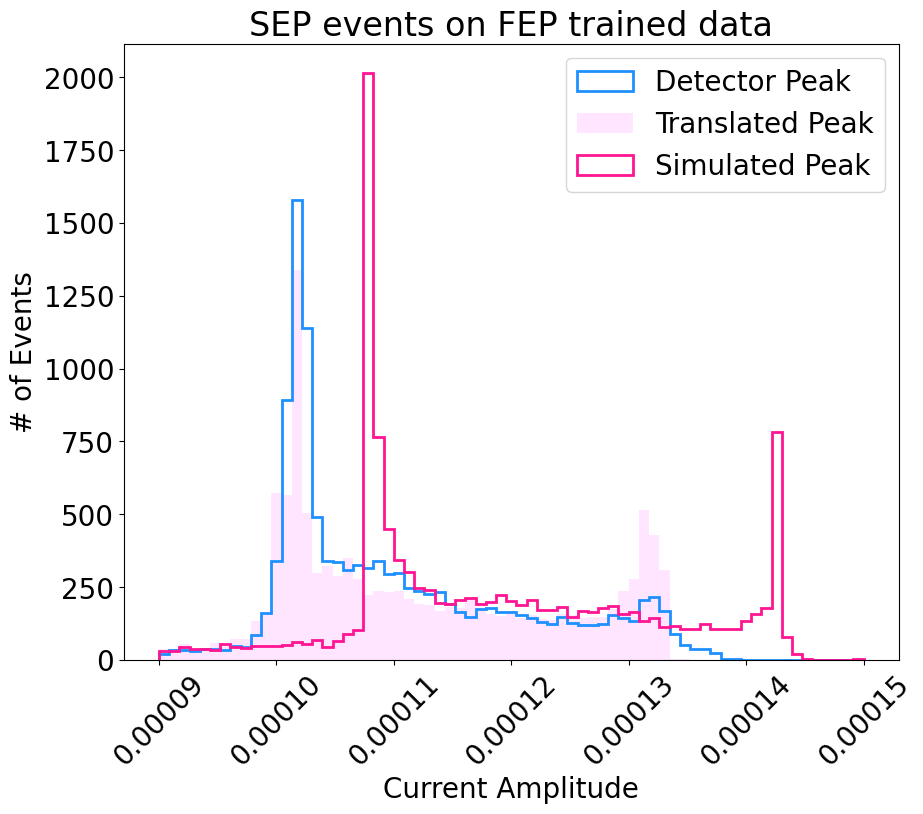

In [161]:
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (10,8)
# rg = np.linspace(0.000125, 0.00015, 50)
rg = np.linspace(0.00009, 0.00015, 70)
# rg=200
plt.hist(ca,label="Detector Peak",bins=rg, histtype="step",linewidth=2,color="dodgerblue")
plt.hist(gan_ca,label="Translated Peak",bins=rg,alpha=0.1,color="magenta")
plt.hist(sim_ca,label="Simulated Peak",bins=rg,linewidth=2,histtype="step",color="deeppink")
plt.xlabel("Current Amplitude")
plt.xticks(rotation=45)
plt.ylabel("# of Events")
plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data")
plt.legend(loc="upper right")


print(f"IoU between Detector Peak and Simulated Peak: {calculate_iou(ca, sim_ca, rg, normed=False):.10f}")
print(f"IoU between Detector Peak and Translated Peak: {calculate_iou(ca, gan_ca, rg, normed=False):.10f}")

# plt.yscale("log")
# plt.savefig("figs/dep_current_amp.png",dpi=200)

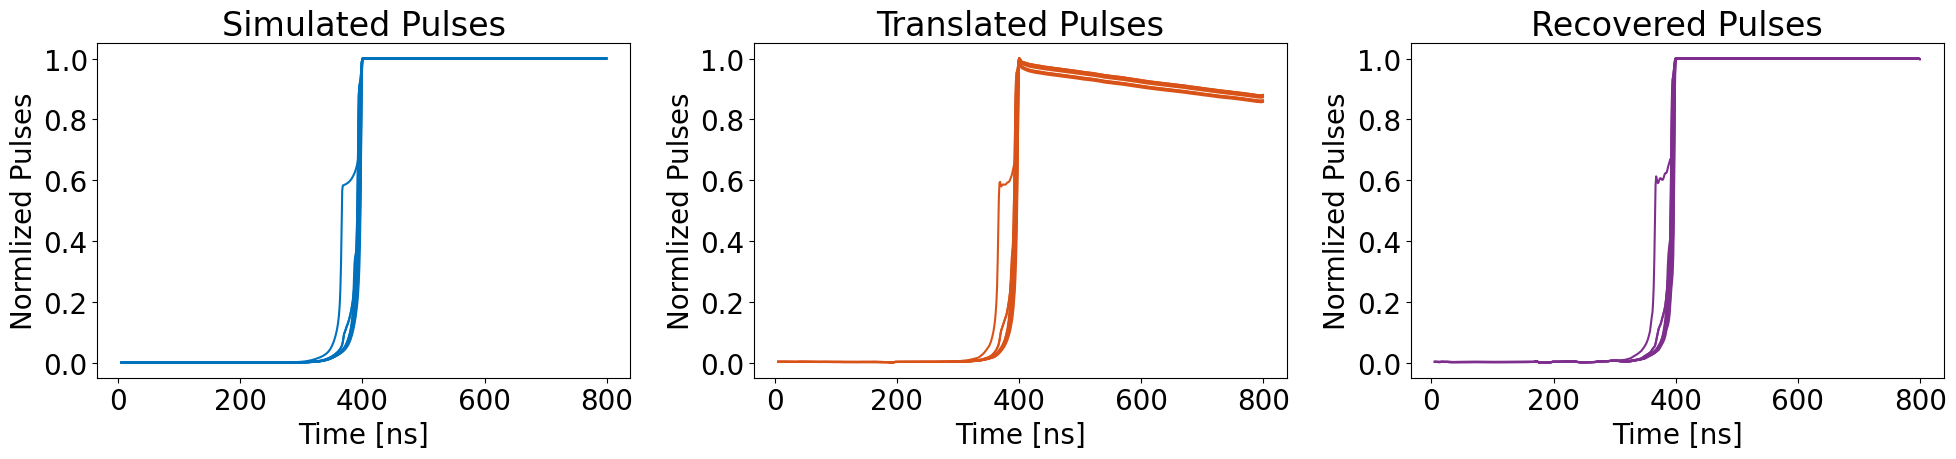

In [162]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cycle_BAB_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", eng_peak_load="eng_peak_load"):
    # Initialize lists to store waveforms
    real_Bs, fake_As, recovered_Bs, real_As = [], [], [], []

    time = np.linspace(0, 799, 800)
    cut = time > 5  

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B, a, b = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate and recover
        with torch.no_grad():
            fake_A = netG_B2A(real_B)
            recovered_B = netG_A2B(fake_A)

        # Collect waveforms
        real_Bs.append(real_B[0, 0, :].cpu().numpy())
        fake_As.append(fake_A[0, 0, :].cpu().numpy())
        recovered_Bs.append(recovered_B[0, 0, :].cpu().numpy())
        real_As.append(real_A[0, 0, :].cpu().numpy())

       # Plotting
    colors = {
        "real_B": "#0072BD",  # bright blue
        "fake_A": "#D95319",  # bright orange
        "recovered_B": "#7E2F8E",  # purple
    }

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))  
    titles = ["Simulated Pulses", "Translated Pulses", "Recovered Pulses"]
    waveform_lists = [real_Bs, fake_As, recovered_Bs]
    color_keys = ["real_B", "fake_A", "recovered_B"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut], waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_title(title)
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Normlized Pulses')
        # ax.legend(loc='upper right')

    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.savefig("figs/result_comp_1x3_cycle_BAB.png")
    plt.show()
    
plot_cycle_BAB_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=10, eng_peak="SEP", eng_peak_load="DEP")


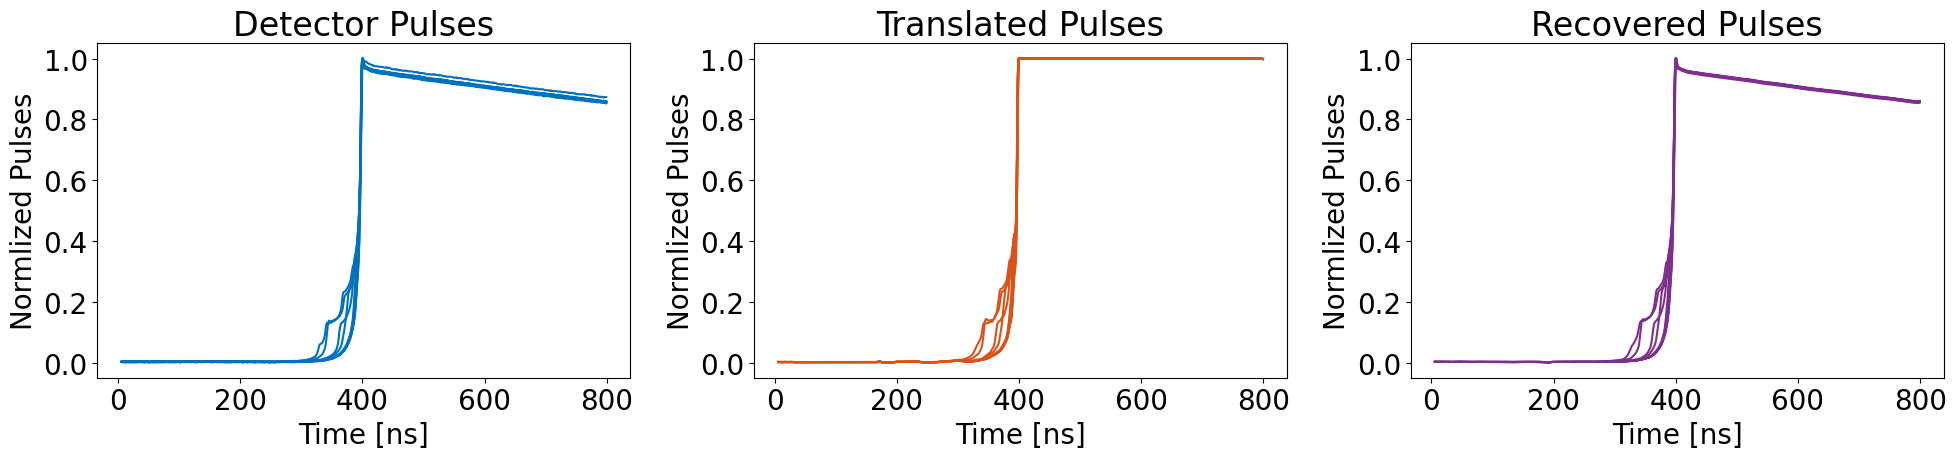

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_cycle_ABA_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", eng_peak_load="eng_peak_load"):
    # Initialize lists to store waveforms
    real_As, fake_Bs, recovered_As = [], [], []

    time = np.linspace(0, 799, 800)
    cut = time > 5  

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B,a,b = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate and recover
        with torch.no_grad():
            fake_B = netG_A2B(real_A)
            recovered_A = netG_B2A(fake_B)

        # Collect waveforms
        real_As.append(real_A[0, 0, :].cpu().numpy())
        fake_Bs.append(fake_B[0, 0, :].cpu().numpy())
        recovered_As.append(recovered_A[0, 0, :].cpu().numpy())

    # Plotting
    colors = {
        "real_A": "#0072BD",  # bright blue
        "fake_B": "#D95319",  # bright orange
        "recovered_A": "#7E2F8E",  # purple
    }

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    titles = ["Detector Pulses", "Translated Pulses", "Recovered Pulses"]
    waveform_lists = [real_As, fake_Bs, recovered_As]
    color_keys = ["real_A", "fake_B", "recovered_A"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut], waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_title(title)
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Normlized Pulses')
        # ax.legend(loc='upper right')

    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.savefig("figs/result_comp_1x3_cycle_ABA.png")
    plt.show()

plot_cycle_ABA_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=10, eng_peak="DEP", eng_peak_load="FEP")


In [164]:
sep_alignment, peak_location_ca_sep, peak_location_gan_ca_sep = check_peak_alignment(train_loader, ATN, 0, DEVICE)
# Print the location of the peaks for both sep and dep
print(f"SEP Peak location for ca: {peak_location_ca_sep:.6f}, gan_ca: {peak_location_gan_ca_sep:.6f}")

SEP Peak location for ca: 0.000102, gan_ca: 0.000102


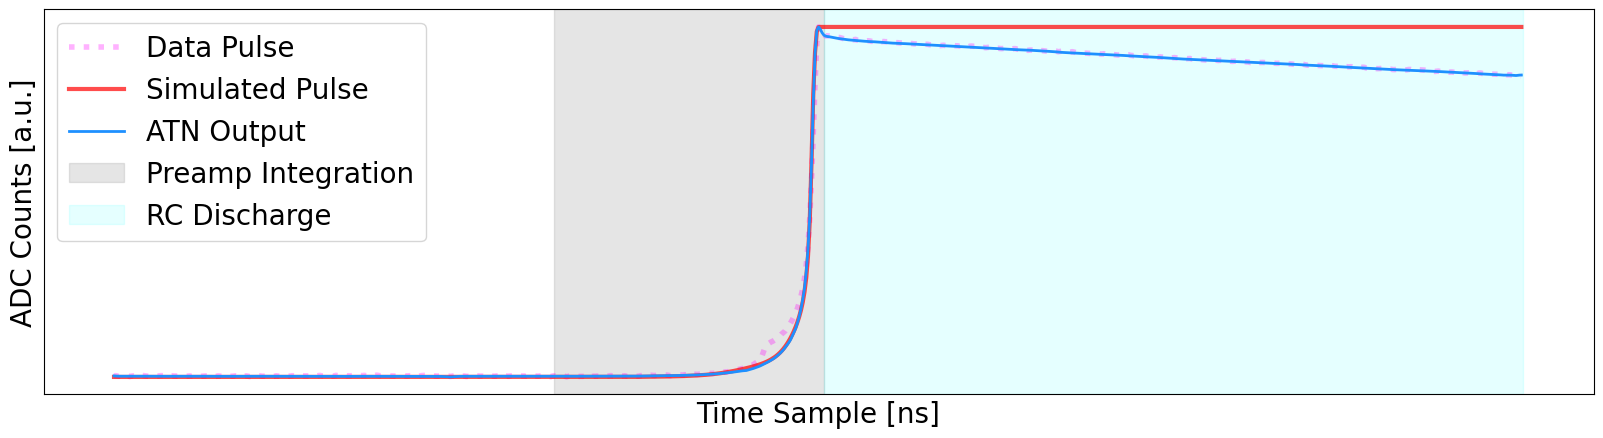

In [165]:
# wf, wf_deconv, a, b = next(iter(train_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
outputs_inv = IATN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()
fig = plt.figure(figsize=(20, 5))
plt.plot(detector_pulse, label="Data Pulse",alpha=0.3, color="magenta", linestyle=":",linewidth = 4)
plt.plot(simulated_pulse, label="Simulated Pulse",alpha=0.7, color="red", linewidth = 3)
plt.plot(translated_pulse, label="ATN Output",color="dodgerblue", linewidth = 2)
plt.axvspan(xmin=250,xmax=403,alpha=0.2,color="grey", label="Preamp Integration")
plt.axvspan(xmin=403,xmax=800,alpha=0.1,color="cyan",label="RC Discharge")
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Time Sample [ns]")
plt.ylabel("ADC Counts [a.u.]")
# ax_main.plot(orwf, label="Data->Siggen",alpha=0.3,color="green", linewidth = 5)
# plt.gca().get_xaxis().set_visible(False)
# plt.gca().get_yaxis().set_visible(False)
plt.legend(loc="upper left")
# plt.xlim(200, 600)
plt.savefig("figs/ATN.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

In [166]:
# import torch
# import pickle
# from tqdm import tqdm

# IATN.eval()

# # Placeholder for collected data
# collected_data = []

# for i, (wf, wf_deconv, rawwf, event_ids) in enumerate(tqdm(train_loader)):
#     # Transfer waveforms to DEVICE
#     wf_deconv = wf_deconv.to(DEVICE).float()

#     # Process through IATN
#     with torch.no_grad():
#         transformed_wf = ATN(wf_deconv)

#     # Convert tensors to CPU and numpy for storage
#     transformed_wf_np = transformed_wf.cpu().numpy()
#     wf_np = wf.cpu().numpy()
#     wf_deconv_np = wf_deconv.cpu().numpy()

#     # Store the necessary information
#     for j in range(wf_np.shape[0]):
#         collected_data.append({
#             'event_id': event_ids[j].item(),  # Assuming event_ids is a tensor of event IDs
#             # 'original_wf': wf_np[j],
#             'simulated_wf': wf_deconv_np[j],
#             'transformed_wf': transformed_wf_np[j]
#         })

# # Save to a pickle file
# with open('transformed_waveforms_with_events.pickle', 'wb') as handle:
#     pickle.dump(collected_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# print("Data saved successfully.")

In [167]:
# import pickle
# import matplotlib.pyplot as plt

# # Load the pickle file
# with open('transformed_waveforms_with_events.pickle', 'rb') as handle:
#     loaded_data = pickle.load(handle)

# # Choose a sample to plot
# sample_index = 0  # For example, let's plot the first sample

# # Access the waveforms from the chosen sample
# sample_data = loaded_data[sample_index]
# simulated_wf = sample_data['simulated_wf'][0]
# transformed_wf = sample_data['transformed_wf'][0]
# event_id = sample_data['event_id']

# # Plotting
# plt.figure(figsize=(12, 8))

# # Simulated waveform
# plt.plot(simulated_wf, label='Simulated Waveform', color='orange')
# plt.title('Simulated Waveform')
# plt.legend()

# # Transformed waveform
# plt.plot(transformed_wf, label='Transformed Waveform', color='green')
# plt.title('Transformed Waveform')
# plt.legend()

# plt.tight_layout()
# plt.show()